In [26]:
import numpy as np
import warnings
import pims
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series  # for convenience


def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),option=1,ploton=False):
	"""
	Anisotropic diffusion.

	Usage:
	imgout = anisodiff(im, niter, kappa, gamma, option)

	Arguments:
	        img    - input image
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the image will be plotted on every iteration

	Returns:
	        imgout   - diffused image.

	kappa controls conduction as a function of gradient.  If kappa is low
	small intensity gradients are able to block conduction and hence diffusion
	across step edges.  A large value reduces the influence of intensity
	gradients on conduction.

	gamma controls speed of diffusion (you usually want it at a maximum of
	0.25)

	step is used to scale the gradients in case the spacing between adjacent
	pixels differs in the x and y axes

	Diffusion equation 1 favours high contrast edges over low contrast ones.
	Diffusion equation 2 favours wide regions over smaller ones.

	Reference: 
	P. Perona and J. Malik. 
	Scale-space and edge detection using ansotropic diffusion.
	IEEE Transactions on Pattern Analysis and Machine Intelligence, 
	12(7):629-639, July 1990.

	Original MATLAB code by Peter Kovesi  
	School of Computer Science & Software Engineering
	The University of Western Australia
	pk @ csse uwa edu au
	<http://www.csse.uwa.edu.au>

	Translated to Python and optimised by Alistair Muldal
	Department of Pharmacology
	University of Oxford
	<alistair.muldal@pharm.ox.ac.uk>

	June 2000  original version.       
	March 2002 corrected diffusion eqn No 2.
	July 2012 translated to Python
	"""

	# ...you could always diffuse each color channel independently if you
	# really want
	if img.ndim == 3:
		warnings.warn("Only grayscale images allowed, converting to 2D matrix")
		img = img.mean(2)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest',cmap="Greys_r")
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True,cmap="Greys_r")
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in range(niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaS/kappa)**2.)/step[0]
			gE = np.exp(-(deltaE/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaS/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaE/kappa)**2.)/step[1]

		# update matrices
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'North/West' by one
		# pixel. don't as questions. just do it. trust me.
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout

def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):
	"""
	3D Anisotropic diffusion.

	Usage:
	stackout = anisodiff(stack, niter, kappa, gamma, option)

	Arguments:
	        stack  - input stack
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (z,y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the middle z-plane will be plotted on every 
	        	 iteration

	Returns:
	        stackout   - diffused stack.

	kappa controls conduction as a function of gradient.  If kappa is low
	small intensity gradients are able to block conduction and hence diffusion
	across step edges.  A large value reduces the influence of intensity
	gradients on conduction.

	gamma controls speed of diffusion (you usually want it at a maximum of
	0.25)

	step is used to scale the gradients in case the spacing between adjacent
	pixels differs in the x,y and/or z axes

	Diffusion equation 1 favours high contrast edges over low contrast ones.
	Diffusion equation 2 favours wide regions over smaller ones.

	Reference: 
	P. Perona and J. Malik. 
	Scale-space and edge detection using ansotropic diffusion.
	IEEE Transactions on Pattern Analysis and Machine Intelligence, 
	12(7):629-639, July 1990.

	Original MATLAB code by Peter Kovesi  
	School of Computer Science & Software Engineering
	The University of Western Australia
	pk @ csse uwa edu au
	<http://www.csse.uwa.edu.au>

	Translated to Python and optimised by Alistair Muldal
	Department of Pharmacology
	University of Oxford
	<alistair.muldal@pharm.ox.ac.uk>

	June 2000  original version.       
	March 2002 corrected diffusion eqn No 2.
	July 2012 translated to Python
	"""

	# ...you could always diffuse each color channel independently if you
	# really want
	if stack.ndim == 4:
		warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
		stack = stack.mean(3)

	# initialize output array
	stack = stack.astype('float32')
	stackout = stack.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(stackout)
	deltaE = deltaS.copy()
	deltaD = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	UD = deltaS.copy()
	gS = np.ones_like(stackout)
	gE = gS.copy()
	gD = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		showplane = stack.shape[0]//2

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
		ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
		ax1.set_title("Original stack (Z = %i)" %showplane)
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in xrange(niter):

		# calculate the diffs
		deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
		deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
		deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)

		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gD = np.exp(-(deltaD/kappa)**2.)/step[0]
			gS = np.exp(-(deltaS/kappa)**2.)/step[1]
			gE = np.exp(-(deltaE/kappa)**2.)/step[2]
		elif option == 2:
			gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
			gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
			gE = 1./(1.+(deltaE/kappa)**2.)/step[2]

		# update matrices
		D = gD*deltaD
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'Up/North/West' by one
		# pixel. don't as questions. just do it. trust me.
		UD[:] = D
		NS[:] = S
		EW[:] = E
		UD[1:,: ,: ] -= D[:-1,:  ,:  ]
		NS[: ,1:,: ] -= S[:  ,:-1,:  ]
		EW[: ,: ,1:] -= E[:  ,:  ,:-1]

		# update the image
		stackout += gamma*(UD+NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(stackout[showplane,...].squeeze())
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return stackout

In [5]:
pic = plt.imread('/Users/cgroschner/Box Sync/Research/HR-TEM/8bit/Cd_CdSe_031517_multi.tif')

In [6]:
cleanpic = anisodiff(pic)

In [7]:
from scipy.misc import imread
%matplotlib inline
from skimage import io

In [8]:
im = imread('/Users/cgroschner/Box Sync/Research/HR-TEM/8bit/Cd_CdSe_031517_multi.tif')

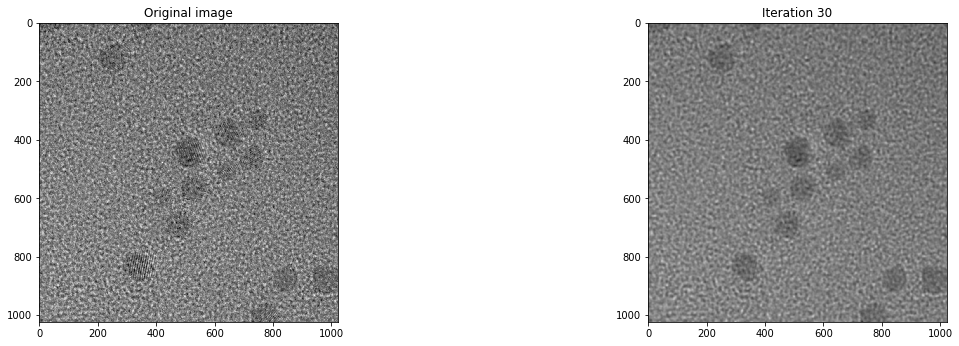

In [29]:
frame = anisodiff(im, niter=30, kappa=70,ploton=True)
#plt.imshow(im, cmap="Greys_r")
#plt.figure()
#plt.imshow(frame, cmap="Greys_r")

In [30]:
imag = im.flatten()

(array([  2.00000000e+02,   9.06500000e+03,   1.23254000e+05,
          3.71898000e+05,   3.83290000e+05,   1.35785000e+05,
          2.32170000e+04,   1.79000000e+03,   7.40000000e+01,
          3.00000000e+00]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

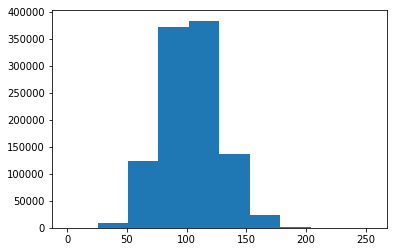

In [31]:
plt.hist(imag)

(array([  1.55000000e+02,   2.69500000e+03,   3.16210000e+04,
          1.53602000e+05,   3.37409000e+05,   3.27144000e+05,
          1.51403000e+05,   3.91260000e+04,   5.00100000e+03,
          4.20000000e+02]),
 array([  37.30512238,   50.45553055,   63.60593872,   76.75634689,
          89.90675507,  103.05716324,  116.20757141,  129.35797958,
         142.50838776,  155.65879593,  168.8092041 ]),
 <a list of 10 Patch objects>)

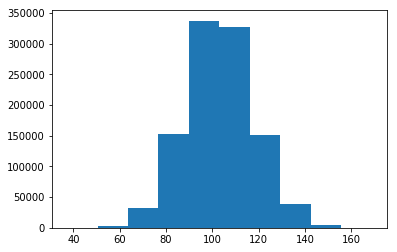

In [32]:
fram = frame.flatten()
plt.hist(fram)

In [33]:
io.imsave('Cd_CdSe_031517_multi_aniso.tiff', frame)

In [ ]:
import trackpy as tp

In [34]:
frames = pims.ImageSequence('Cd_CdSe_031517_multi_aniso.tiff', as_grey=True)

In [35]:
f = tp.locate(frames[0], 137, invert=True)
f.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame
0,247.904429,106.819302,131043.276454,45.213283,0.196960,48.383696,-1333722.875,NaN,0
1,479.501516,218.016719,73838.166821,48.897961,0.026888,40.183069,-1443735.000,NaN,0
2,879.945055,261.794824,70462.242283,47.742878,0.014110,35.536048,-1401466.125,NaN,0
3,71.617584,261.320035,64831.692192,47.824223,0.022722,34.989339,-1500601.500,NaN,0
4,648.578548,388.074777,112165.161109,43.093503,0.186257,43.189966,-1375637.500,NaN,0


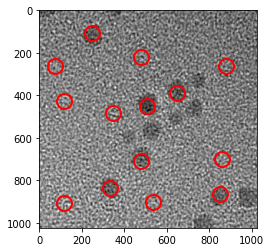

In [36]:
plt.figure()  # make a new figure
tp.annotate(f,frames[0]);